### DEADLINE  11.02.2022

Само Дз описано в конце ноутбука

# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.7.1'

In [3]:
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [4]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=transforms.ToTensor())

0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


//anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [11]:
for i in trainset:
    break

In [13]:
type(i)

tuple

In [15]:
i[1]

9

In [5]:
trainset[0][0]*255

tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   1.,   0.,   0.,  13.,  73.,   0.,   0.,   1.,   4.,   0.,
            0.,   0.,   0.,   1.,   1.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   3.,   0.,  36., 136., 127.,  62.,  54.,   0.,   0.,   0.,
            1.,   3.,   4.,   0.,   0.,   3.],
     

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

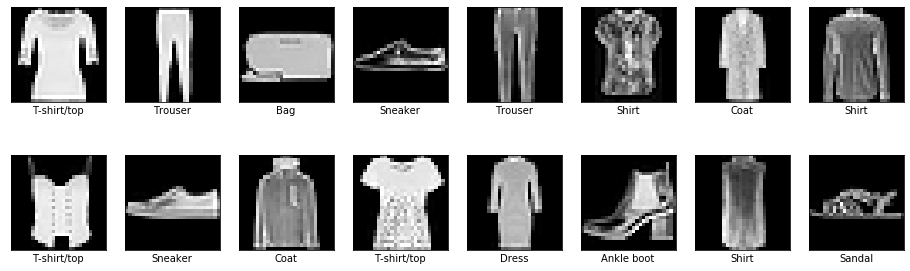

In [7]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [8]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [9]:
class FC(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(784, 64),  # 28 x 28 = 784
                                        nn.BatchNorm1d(64),
                                        nn.ReLU(),
                                        nn.Linear(64, 32),
                                        nn.BatchNorm1d(32),
                                        nn.ReLU(),
                                        nn.Linear(32, 16),
                                        nn.BatchNorm1d(16),
                                        nn.ReLU(),
                                        nn.Linear(16, 10),
                                    )
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs

In [16]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
iter(trainloader).next()[0].shape

torch.Size([512, 1, 28, 28])

In [17]:
torch.cuda.is_available()

False

In [ ]:
# !watch -n 5 nvidia-smi

In [18]:
device = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_fc = FC()
model_fc.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_fc.parameters(), lr=0.01)

cpu


In [20]:
model_fc()

FC(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [21]:
for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        break

In [23]:
logit,proba = model_fc(inputs)

In [24]:
proba

tensor([[0.0888, 0.0427, 0.0415,  ..., 0.0903, 0.1122, 0.0724],
        [0.0814, 0.0531, 0.0369,  ..., 0.0904, 0.1488, 0.1322],
        [0.1074, 0.0965, 0.0494,  ..., 0.1063, 0.1279, 0.1066],
        ...,
        [0.0753, 0.0358, 0.0381,  ..., 0.1895, 0.0647, 0.1687],
        [0.1080, 0.0968, 0.0466,  ..., 0.0819, 0.1234, 0.0940],
        [0.0863, 0.0731, 0.0614,  ..., 0.1294, 0.1133, 0.1025]],
       grad_fn=<SoftmaxBackward>)

In [25]:
logit

tensor([[-0.0674, -0.7985, -0.8283,  ..., -0.0510,  0.1663, -0.2719],
        [-0.0735, -0.5007, -0.8639,  ...,  0.0311,  0.5293,  0.4116],
        [ 0.1401,  0.0329, -0.6360,  ...,  0.1291,  0.3145,  0.1321],
        ...,
        [ 0.1150, -0.6279, -0.5649,  ...,  1.0382, -0.0360,  0.9221],
        [ 0.1311,  0.0217, -0.7097,  ..., -0.1455,  0.2648, -0.0077],
        [-0.0922, -0.2574, -0.4330,  ...,  0.3134,  0.1808,  0.0805]],
       grad_fn=<AddmmBackward>)

In [27]:
def train_nn(trainloader, model, opt, loss_fn, device):
    running_loss = []

    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # Взятие данных
        inputs = inputs.to(device)

        opt.zero_grad()
        outputs,probs = model(inputs)
        loss = loss_fn(outputs.cpu(), labels)
        loss.backward()
        opt.step()
        
        running_loss.append(loss.item())

    return model, running_loss


def eval_nn(testloader, model, loss_fn, device):
    running_loss_test = []

    model.eval()
    predicts = np.array([])
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs,proba = model(inputs)
        predicts = np.append(predicts, outputs.cpu().argmax(dim=1).numpy())
        loss = loss_fn(outputs.cpu(), labels)

        running_loss_test.append(loss.item())
    return running_loss_test, predicts.astype(int)

In [28]:
def training_loop(model, trainloader, testloader, opt, loss_fn, device, max_epochs=20):
    loss_arr = []
    loss_arr_test = []

    for epoch in range(max_epochs):        
        model, running_loss = train_nn(trainloader, model, opt, loss_fn, device)
        running_loss_test, _ = eval_nn(testloader, model, loss_fn, device)

        loss_arr.append(np.mean(running_loss))
        loss_arr_test.append(np.mean(running_loss_test))

        if epoch % 4 == 0:
            print(f'EPOCH {epoch} : train_loss: {loss_arr[-1]:.5f} test_loss: {loss_arr_test[-1]:.5f}')

    return loss_arr, loss_arr_test


def plot(loss_arr, loss_arr_test):
    plt.plot(loss_arr, label='Train loss')
    plt.plot(loss_arr_test, label='Validation loss')
    plt.legend();

In [29]:
loss_arr, loss_arr_test = training_loop(model_fc, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

EPOCH 0 : train_loss: 1.71541 test_loss: 1.45070
EPOCH 4 : train_loss: 0.70948 test_loss: 0.68674
EPOCH 8 : train_loss: 0.47581 test_loss: 0.55378
EPOCH 12 : train_loss: 0.39242 test_loss: 0.44275
EPOCH 16 : train_loss: 0.34838 test_loss: 0.41363


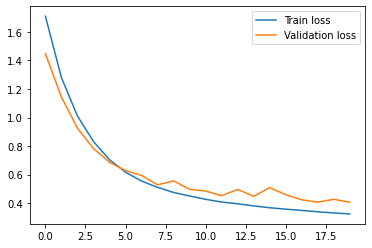

In [ ]:
plot(loss_arr, loss_arr_test)

In [30]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.4808865040540695


Можно посмотреть, где именно сетка ошибается. 

In [31]:
_, y_pred = eval_nn(testloader, model_fc, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors =  y_pred != y_test

# срежем только наблюдения, где была ошибка вместе с метками
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

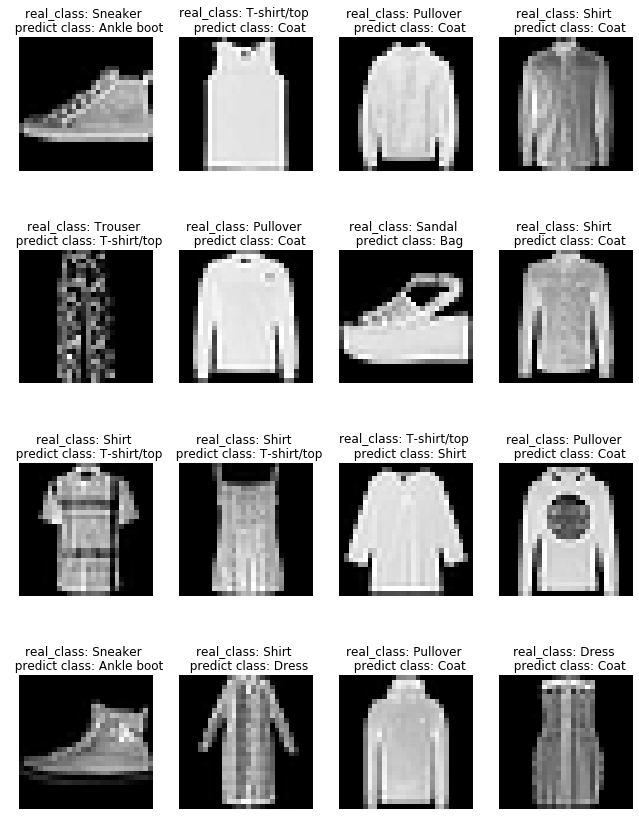

In [32]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

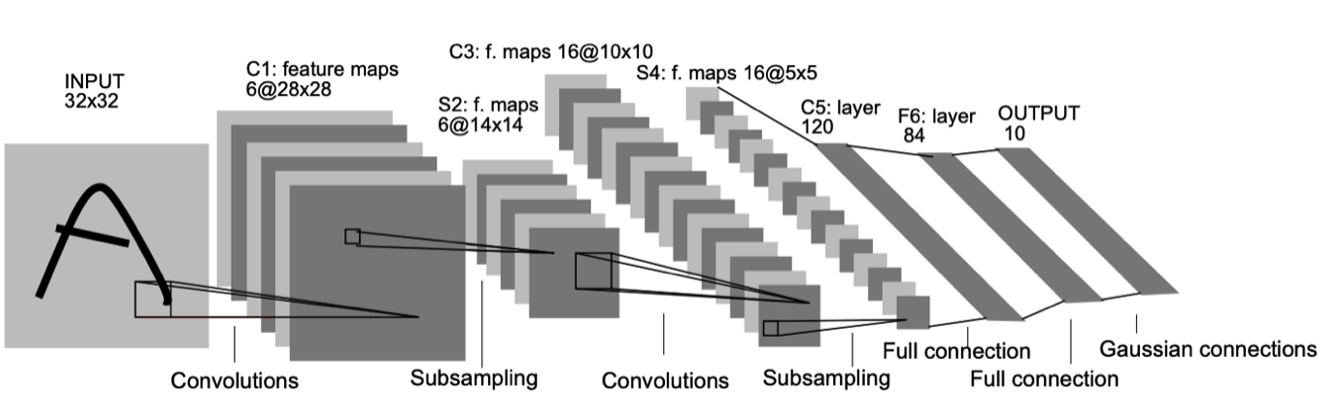

In [33]:
display.Image('images/lenet.png', retina=True)

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding

In [41]:
(28-5+0)+1

24

In [ ]:
nn.Conv3d()

In [42]:
# 
#  Ваша LeNet сетка :) 
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 1,
                                                  out_channels=6,
                                                  kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=6,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs
#         return logits

In [49]:
inputs[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [48]:
nn.Flatten()(inputs[0])

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [46]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# model_cnn = CNN()
# model_cnn.to(device)
# loss_fn = nn.CrossEntropyLoss()
# opt = optim.SGD(model_cnn.parameters(), lr=0.01)

# loss_arr, loss_arr_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

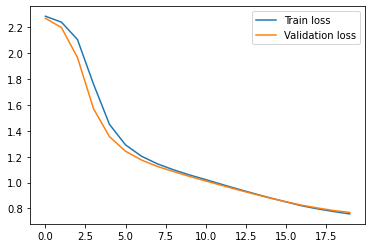

In [ ]:
plot(loss_arr, loss_arr_test)

In [ ]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.7689385384321212


In [ ]:
#отрисовка результатов
y_pred = model_2.predict_classes(X_test)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

Точность должна была довольно сильно подскочить, но пока этого не произошло. \

**Домашнее задание:** 
1. добавить в pipeline расчет точности в дополнение к loss (функция  training_loop)
2. улучшить качество обеих моделей (FC и CNN). В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
3. Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

#### Доп инфа на посмотреть:
Посмотрите на качество получившейся модели. Добавьте строки перевода пикселей картинки на отрезок -[0;255].
Переобучите сетку. Что произошло с качеством? (сравните еще эту ситуацию в модели с батчнормом и без)

Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?
